# ReadMe

Unless explicitly specified, the basic units in this notebook are constructed from um, fs and keV without other constant.

In [1]:
import sys
sys.path.append("../../../XRaySimulation")

import numpy as np
import matplotlib.pyplot as plt

from XRaySimulation import util, misc, Crystal

 ![](Example1.png)

# Specify the crystal 

In [9]:
# The length of the reciprocal lattice
h_length = 2. * np.pi / (2.0593 * 1e-4)

# Some crystal properties
chi_dict = {"chi0":complex(-0.16194E-04 ,     0.15257E-07),
            "chih_sigma":complex(0.58984E-05 , - 0.10603E-07 ),
            "chihbar_sigma":complex(0.58984E-05 , - 0.10603E-07),
            "chih_pi":complex(0.47139E-05, -0.83666E-08),
            "chihbar_pi":complex(0.47139E-05, -0.83666E-08)
           }

# Asymmetric angle
alphas = -np.deg2rad(0.)

# Initialize the crystals
my_crystal = Crystal.CrystalBlock3D(h=np.array([0, h_length, 0]),
                                         normal=-np.array([0., np.cos(alphas),np.sin(alphas)]),
                                         surface_point=np.zeros(3),
                                         thickness=1e6,
                                         chi_dict=chi_dict)

# Set the thickness of the crystal
my_crystal.set_thickness(d = 1e6) # Set the thickness to be 1e6 um = 1m

# Specify incident wave vectors

In [15]:
central_energy = 9.5 #kev
number_wavevec = 1000  # The number of wave vector to calculate 
energy_range = 3e-3 #keV.  The energy to calculate the reflectivity

In [16]:
# Convert the energy to the wave vector
central_wavevec = np.array([0,0, util.kev_to_wave_number(central_energy)])

# Get the wave vector array and other axes info
k_in_grid, axis_info = util.get_k_mesh_1d(number = number_wavevec, energy_range = energy_range)

# Add the reference wave vector to the wave vector
k_in_grid += central_wavevec[np.newaxis, :]

# Define the bragg angle to rotate the wave vector array
bragg = util.get_bragg_angle(wave_length = np.pi * 2 / util.kev_to_wave_number(energy=central_energy),
                             plane_distance = np.pi * 2 / h_length)
print("The bragg angle is {:.2f} degree".format(np.rad2deg(bragg)))

# Ajust the Bragg angle a bit
"""
This is just used to shift the rocking curve to the center.
This is not necessary.
"""
bragg += 11e-6

# Get the rotation matrix for the rotation
rot_mat = util.rot_mat_in_yz_plane(theta= bragg)

# Rotate the wave vectors
k_in_grid = np.dot(k_in_grid, rot_mat.T)

The bragg angle is 18.47 degree


# Get the reflectivity

In [17]:
(reflect_sigma, 
 reflect_pi,
 b,
 kout_grid) = util.get_bragg_reflection_array(kin_grid = k_in_grid,
                                         d = my_crystal.thickness,
                                         h = my_crystal.h,
                                         n = my_crystal.normal,
                                         chi0 = my_crystal.chi0,
                                         chih_sigma = my_crystal.chih_sigma,
                                         chihbar_sigma = my_crystal.chihbar_sigma,
                                         chih_pi = my_crystal.chih_pi,
                                         chihbar_pi = my_crystal.chihbar_pi)
print("Finish calculating the reflectivity")

sigma_reflectivity = np.abs(np.square(reflect_sigma)) / np.abs(b)
pi_reflectivity = np.abs(np.square(reflect_pi)) / np.abs(b)

Finish calculating the reflectivity


# Show the reflectivity

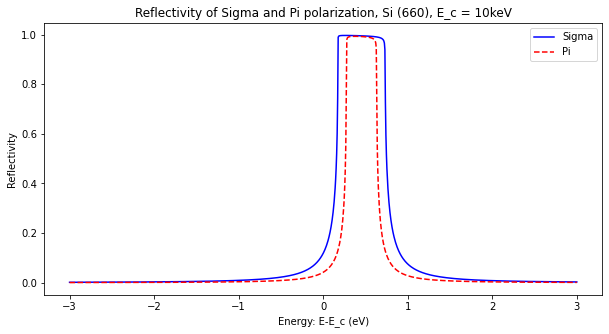

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(10)

axes.plot(axis_info['energy_grid'] * 1000, sigma_reflectivity,'b', label="Sigma")
axes.plot(axis_info['energy_grid'] * 1000, pi_reflectivity,'r--', label="Pi")

axes.legend(loc = "upper right")
axes.set_title("Reflectivity of Sigma and Pi polarization, Si (660), E_c = 10keV")
axes.set_xlabel("Energy: E-E_c (eV)")
axes.set_ylabel("Reflectivity")

plt.show()


# Get Bandwidth

In [19]:
fwhm_sigma = misc.get_fwhm(coordinate=axis_info["energy_grid"],
                           curve_values=sigma_reflectivity)

print("The fwhm of the reflectivity curver of the sigma polarization is")
print("{:.2e} eV".format(fwhm_sigma * 1000))

fwhm_pi = misc.get_fwhm(coordinate=axis_info["energy_grid"],
                           curve_values=pi_reflectivity)

print("The fwhm of the reflectivity curver of the pi polarization is")
print("{:.2e} eV".format(fwhm_pi * 1000))

The fwhm of the reflectivity curver of the sigma polarization is
5.89e-01 eV
The fwhm of the reflectivity curver of the pi polarization is
3.72e-01 eV


In [20]:
util.bandwidth_sigma_kev_to_duration_sigma_fs(util.fwhm_to_sigma(5.89e-01 / 1000))

1.3157645985022555